In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%alias_magic t timeit
%load_ext memory_profiler

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1."
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
# import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.devices()

In [13]:
import jax
import optax

import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from momi3.Params import Params
from momi3.MOMI import Momi
from momi3.optimizers import optax_for_momi
from momi3.utils import bootstrap_sample

import re
import math
import pickle
import tskit

from tqdm.notebook import tqdm, trange

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp

from ast import literal_eval

from train import get_demo, get_params

In [4]:
demo = demes.load("arc5.yaml")

# Sampled model

In [11]:
jsfs = np.load('jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_725679_108.npy')

In [6]:
sampled_demes = ('Yoruba', 'French', 'Papuan', 'Vindija', 'Denisovan')
sample_sizes = [50, 50, 30, 2, 2] # Sampled 50 from YRI and French

sampled_n_dict = dict(zip(sampled_demes, sample_sizes))

## Infer pop sizes

In [8]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True)

In [18]:
params = Params(momi)

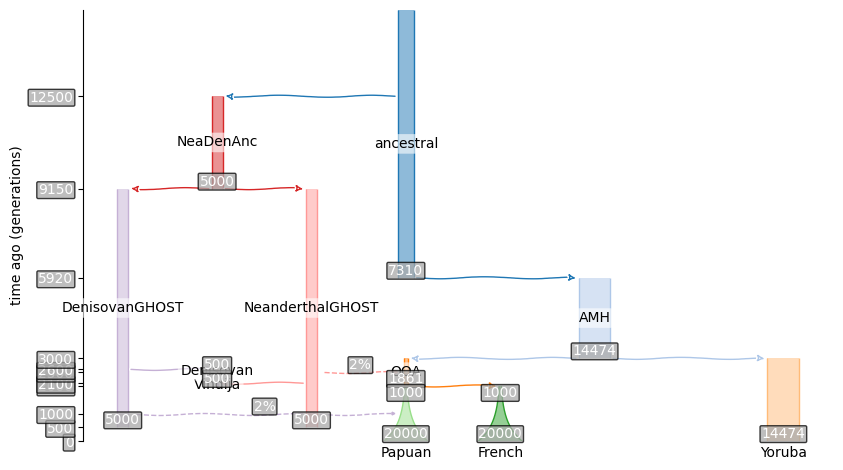

In [27]:
params.tubes(True, False)

In [19]:
params = Params(momi)
params.set_train_all_etas(True)
params.set_train('eta_0', False) # We will not infer the size of ancestral pop
print(f"ancestral size: {params['eta_0']}")

ancestral size: 7310.0


In [20]:
# Initilize OPTAX parameters
optimizer = optax.adam(learning_rate=50.)
theta_train_dict = params.theta_train_dict(True)
opt_state = optimizer.init(theta_train_dict)

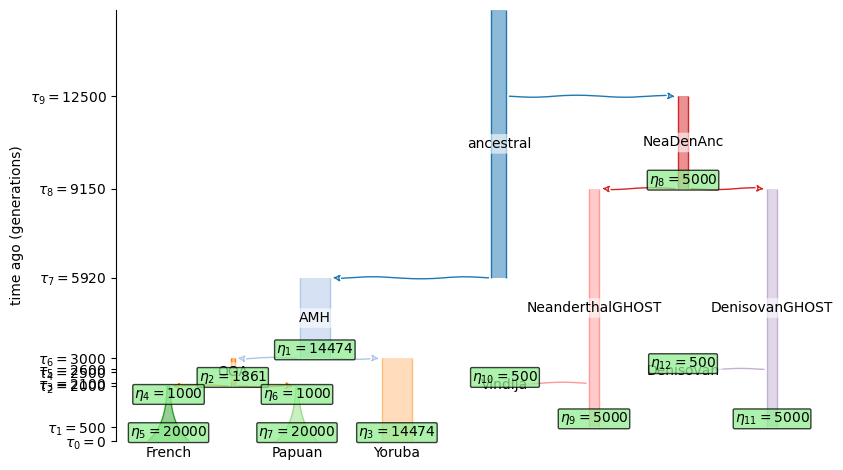

In [22]:
params.tubes(True, True, log_time=False, hide_non_inferreds=True)

In [23]:
# Training
theta_train_dict, opt_state, LL = optax_for_momi(
    optimizer, momi, params, jsfs, niter=500, transformed=True, 
    theta_train_dict=theta_train_dict,
    opt_state=opt_state)

  0%|          | 0/500 [00:00<?, ?it/s]

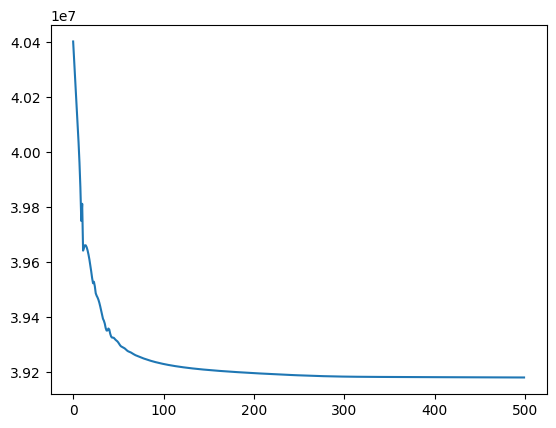

In [24]:
plt.plot(LL)

In [25]:
params.set_optimization_results(theta_train_dict)

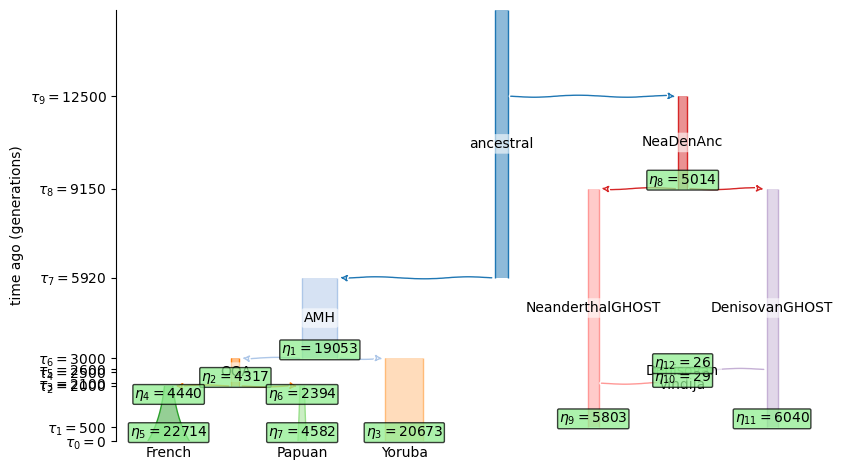

In [27]:
params.tubes(True, True, log_time=False, hide_non_inferreds=True, fontsize=10)

In [29]:
inferred_demo = params.demo_graph

In [35]:
demes.dump(inferred_demo, filename='arc5_pop_size_inferred.yaml', format='yaml', simplified=False)

## Infer admixture params

In [14]:
jsfs = np.load('jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_11979_108.npy')
jsfs = bootstrap_sample(jsfs, n_SNPs=10000, seed=108)

In [15]:
demo = get_demo('pulse')

In [16]:
sampled_demes = ('Yoruba', 'French', 'Papuan', 'Vindija', 'Denisovan')
sample_sizes = [10, 10, 10, 2, 2] # Sampled 50 from YRI and French

In [17]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True)

In [29]:
params = Params(momi)
params.set_train_all_pis(True)

In [53]:
# Initilize OPTAX parameters
optimizer = optax.adam(learning_rate=0.01)
theta_train_dict = params.theta_train_dict(True)
opt_state = optimizer.init(theta_train_dict)

In [54]:
LL = []

In [57]:
# Training
theta_train_dict, opt_state, LL = optax_for_momi(
    optimizer, momi, params, jsfs, niter=500, transformed=True, 
    theta_train_dict=theta_train_dict,
    opt_state=opt_state,
    LL=LL
)

  0%|          | 0/500 [00:00<?, ?it/s]

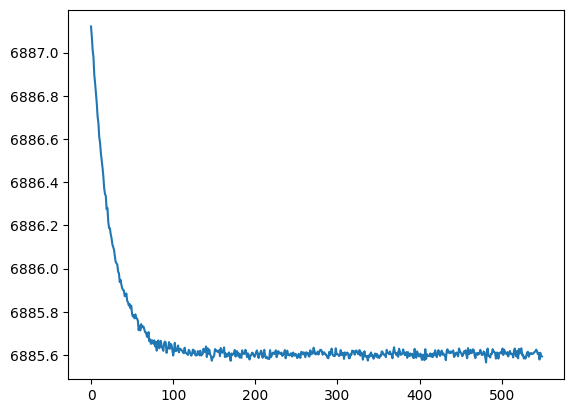

In [58]:
plt.plot(LL)

In [60]:
params.set_optimization_results(theta_train_dict)

In [61]:
params

Parameter,Value,Infer
┦,7.31e+03,❌
𗎆,29.5,❌
𗎇,6.04e+03,❌
𗎈,26.5,❌
┧,1.91e+04,❌
┨,4.32e+03,❌
┩,2.07e+04,❌
┪,4.44e+03,❌
┫,2.27e+04,❌
┬,2.39e+03,❌
